In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import time

# ------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------
HEADERS = {"User-Agent": "Mozilla/5.0"}
MONTHS = 6
SINCE_DATE = datetime.now() - timedelta(days=MONTHS*30)

# Sites to scrape
SOURCES = {
    "geo": "https://urdu.geo.tv",
    "jang": "https://jang.com.pk/latest/urdu",
    "dawn": "https://www.dawnnews.tv/news/latest-news"
}

# ------------------------------------------------------------
# HELPERS
# ------------------------------------------------------------

def fetch(url):
    """Wrapper to safely fetch HTML pages."""
    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        if r.status_code == 200:
            return r.text
        return None
    except:
        return None


def parse_date(text):
    """Parse Urdu/English dates."""
    text = text.replace("اپ ڈیٹ", "").strip()
    try:
        return datetime.fromisoformat(text)
    except:
        pass

    try:
        return datetime.strptime(text, "%d %B %Y")
    except:
        return None


# ------------------------------------------------------------
# SCRAPERS FOR EACH NEWS SITE
# ------------------------------------------------------------

def scrape_geo():
    """Scrape Geo Urdu latest pages."""
    data = []

    for page in range(1, 10):    # 10 pages × ~20 articles = ~200 samples
        url = f"https://urdu.geo.tv/latest/{page}"
        html = fetch(url)
        if not html:
            continue

        soup = BeautifulSoup(html, "html.parser")
        articles = soup.select(".listing li a")

        for a in articles:
            link = a["href"]
            if not link.startswith("http"):
                link = "https://urdu.geo.tv" + link

            article_html = fetch(link)
            if not article_html:
                continue

            sp = BeautifulSoup(article_html, "html.parser")

            title = sp.select_one("h1").get_text(strip=True)
            content = " ".join([p.get_text(strip=True) for p in sp.select("article p")])
            date_tag = sp.select_one(".datetime")
            date = parse_date(date_tag.get_text(strip=True)) if date_tag else None

            if not date or date < SINCE_DATE:
                continue

            data.append(["Geo", title, date, link, content])
            time.sleep(0.5)

    return data


def scrape_jang():
    """Scrape Jang Urdu."""
    data = []
    base = "https://jang.com.pk"

    html = fetch(SOURCES["jang"])
    if not html:
        return data

    soup = BeautifulSoup(html, "html.parser")
    articles = soup.select(".lead-more a")

    for a in articles:
        link = base + a["href"]
        article_html = fetch(link)
        if not article_html:
            continue

        sp = BeautifulSoup(article_html, "html.parser")

        title = sp.select_one("h1").get_text(strip=True)
        content = " ".join([p.get_text(strip=True) for p in sp.select(".story-detail p")])

        date_tag = sp.select_one(".update-time")
        date = parse_date(date_tag.get_text(strip=True)) if date_tag else None
        if not date or date < SINCE_DATE:
            continue

        data.append(["Jang", title, date, link, content])
        time.sleep(0.5)

    return data


def scrape_dawn():
    """Scrape Dawn Urdu news."""
    data = []
    base = "https://www.dawnnews.tv"

    html = fetch(SOURCES["dawn"])
    if not html:
        return data

    soup = BeautifulSoup(html, "html.parser")
    articles = soup.select(".box.story a")

    for a in articles:
        link = base + a["href"]
        article_html = fetch(link)
        if not article_html:
            continue

        sp = BeautifulSoup(article_html, "html.parser")

        title = sp.select_one("h1").get_text(strip=True)
        content = " ".join([p.get_text(strip=True) for p in sp.select(".story__content p")])

        date_tag = sp.select_one(".story__time")
        date = parse_date(date_tag.get_text(strip=True)) if date_tag else None
        if not date or date < SINCE_DATE:
            continue

        data.append(["Dawn", title, date, link, content])
        time.sleep(0.5)

    return data


# ------------------------------------------------------------
# RUN SCRAPER
# ------------------------------------------------------------

print("⏳ Scraping Geo News ...")
geo_data = scrape_geo()

print("⏳ Scraping Jang News ...")
jang_data = scrape_jang()

print("⏳ Scraping Dawn News ...")
dawn_data = scrape_dawn()

# Combine & save
all_data = geo_data + jang_data + dawn_data

df = pd.DataFrame(all_data, columns=["source", "title", "date", "url", "content"])
df.to_csv("urdu_news_last_6_months.csv", index=False, encoding="utf-8-sig")

print(f"🎉 Done! Saved {len(df)} articles.")


⏳ Scraping Geo News ...
⏳ Scraping Jang News ...
⏳ Scraping Dawn News ...
🎉 Done! Saved 0 articles.


In [6]:
df.to_csv("urdu_news_last_6_months.csv", index=False, encoding="utf-8-sig")


In [7]:
import pandas as pd
import re
import unicodedata

# Load dataset
df = pd.read_csv("urdu_news_last_6_months.csv")

print("Before cleaning:", df.shape)

# -------------------------------------------
# 1. Remove duplicates + missing
# -------------------------------------------
df.drop_duplicates(subset=["title", "content"], inplace=True)
df.dropna(subset=["content"], inplace=True)

# -------------------------------------------
# 2. Normalize Urdu text
# -------------------------------------------
def normalize_urdu(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove diacritics (زبر، زیر، پیش)
    arabic_diacritics = re.compile(r"[\u064B-\u0652]")
    text = arabic_diacritics.sub("", text)

    # Normalize Alef forms
    text = re.sub(r"[آأإٱٲٳٵﭐﭑ]", "ا", text)

    # Normalize Yeh forms
    text = re.sub(r"[ىيۍېی]", "ی", text)

    # Normalize Heh forms
    text = re.sub(r"[ھۀۃەہ]", "ہ", text)

    # Remove Tatweel/kashida
    text = re.sub(r"ـ+", "", text)

    return text.strip()


# -------------------------------------------
# 3. Remove english, numbers, punctuation, & noise
# -------------------------------------------
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove English letters
    text = re.sub(r"[A-Za-z]", "", text)

    # Remove digits
    text = re.sub(r"\d+", "", text)

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub("", text)

    # Remove non-letter symbols
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)

    # Collapse extra spaces
    text = re.sub(r"\s+", " ", text)

    return text.strip()


# -------------------------------------------
# 4. Apply cleaning functions
# -------------------------------------------
df["content_clean"] = df["content"].apply(normalize_urdu).apply(clean_text)
df["title_clean"] = df["title"].apply(normalize_urdu).apply(clean_text)

# -------------------------------------------
# 5. Remove empty rows
# -------------------------------------------
df = df[df["content_clean"].str.len() > 10]

print("After cleaning:", df.shape)

# -------------------------------------------
# 6. Save cleaned dataset
# -------------------------------------------
df.to_csv("urdu_news_cleaned.csv", index=False, encoding="utf-8-sig")

df.head()


Before cleaning: (0, 5)
After cleaning: (0, 7)


,source,title,date,url,content,content_clean,title_clean


In [8]:
import pandas as pd

df = pd.read_csv("urdu_news_cleaned.csv")
df.head()      # shows first 5 rows


,source,title,date,url,content,content_clean,title_clean


In [9]:
df.head(20)


,source,title,date,url,content,content_clean,title_clean


In [10]:
import os

os.listdir("/content")


['.config',
 'urdu_news_last_6_months.csv',
 'urdu_news_cleaned.csv',
 'sample_data']

In [11]:
!ls -lh /content


total 12K
drwxr-xr-x 1 root root 4.0K Nov 20 14:30 sample_data
-rw-r--r-- 1 root root   59 Dec  2 18:15 urdu_news_cleaned.csv
-rw-r--r-- 1 root root   33 Dec  2 18:14 urdu_news_last_6_months.csv


In [12]:
import pandas as pd

df = pd.read_csv("urdu_news_last_6_months.csv")
df.head()
df.shape


(0, 5)

In [13]:
import pandas as pd

df_raw = pd.read_csv("urdu_news_last_6_months.csv")
df_raw.shape
df_raw.head()


,source,title,date,url,content


In [15]:
!pip install feedparser

import feedparser
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta

SINCE = datetime.now() - timedelta(days=180)
HEADERS = {"User-Agent": "Mozilla/5.0"}

RSS_FEEDS = {
    "BBC": "https://www.bbc.com/urdu/index.xml",
    "Express": "https://www.express.pk/feed/",
    "Dawn": "https://www.dawnnews.tv/feed",
    "HumNews": "https://humnews.pk/category/pakistan/feed/"
}

def fetch_article(url):
    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        soup = BeautifulSoup(r.text, "html.parser")
        paras = soup.find_all("p")
        return " ".join([p.get_text(strip=True) for p in paras])
    except:
        return ""

all_data = []

for source, feed in RSS_FEEDS.items():
    print(f"Fetching from: {source}")
    rss = feedparser.parse(feed)

    for entry in rss.entries:
        # Parse date
        try:
            published = datetime(*entry.published_parsed[:6])
        except:
            continue

        if published < datetime.now() - timedelta(days=180):
            continue

        title = entry.title
        link = entry.link

        # Fetch full article
        content = fetch_article(link)
        if len(content) < 50:
            continue

        all_data.append([source, title, published, link, content])

df = pd.DataFrame(all_data, columns=["source", "title", "date", "url", "content"])
df.to_csv("urdu_news_last_6_months.csv", index=False, encoding="utf-8-sig")

print("DONE — Total Articles:", len(df))
df.head()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 2.9 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=a813e70624a2309a526fc170fe0d6e68b4cd818b09765533b6ff08232cc0443a
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k
Fetching from: BBC
Fetching from: Express
Fetching from: Dawn
Fetching from: HumNews
DONE — Total Articles: 80


,source,title,date,url,content
0,BBC,عظمیٰ خان کی اڈیالہ جیل میں عمران خان سے ملاقا...,2025-12-02 13:42:17,https://www.bbc.com/urdu/articles/cm2vx8yd1k6o...,تقریباً ایک مہینے بعد سابق وزیرِ اعظم عمران خا...
1,BBC,اسلام آباد میں کم عمر ڈرائیور کی مبینہ ٹکر سے ...,2025-12-02 14:12:26,https://www.bbc.com/urdu/articles/c4g64e0ly4zo...,،تصویر کا ذریعہIslamabad Police ’ثمرین کا چھوٹ...
2,BBC,’10 انچ سکرین‘: سام سنگ کا پہلا ’تین تہوں والا...,2025-12-02 14:58:18,https://www.bbc.com/urdu/articles/c0mp9gmm3jmo...,،تصویر کا ذریعہReuters سام سنگ نے منگل کو اپنے...
3,BBC,رومانوی مشوروں سے مالیاتی مدد تک: امیر اور طاق...,2025-12-02 13:20:38,https://www.bbc.com/urdu/articles/cn5lx49ypxeo...,،تصویر کا ذریعہReuters یہ 2019 میں واشنگٹن کے ...
4,BBC,فیصل آباد میں بیٹے کے ہاتھوں باپ کا مبینہ قتل:...,2025-12-02 10:27:14,https://www.bbc.com/urdu/articles/c20gx60vnr9o...,،تصویر کا ذریعہGetty Images پاکستان کے شہر فیص...


In [16]:
df.head(40)

,source,title,date,url,content
0,BBC,عظمیٰ خان کی اڈیالہ جیل میں عمران خان سے ملاقا...,2025-12-02 13:42:17,https://www.bbc.com/urdu/articles/cm2vx8yd1k6o...,تقریباً ایک مہینے بعد سابق وزیرِ اعظم عمران خا...
1,BBC,اسلام آباد میں کم عمر ڈرائیور کی مبینہ ٹکر سے ...,2025-12-02 14:12:26,https://www.bbc.com/urdu/articles/c4g64e0ly4zo...,،تصویر کا ذریعہIslamabad Police ’ثمرین کا چھوٹ...
2,BBC,’10 انچ سکرین‘: سام سنگ کا پہلا ’تین تہوں والا...,2025-12-02 14:58:18,https://www.bbc.com/urdu/articles/c0mp9gmm3jmo...,،تصویر کا ذریعہReuters سام سنگ نے منگل کو اپنے...
3,BBC,رومانوی مشوروں سے مالیاتی مدد تک: امیر اور طاق...,2025-12-02 13:20:38,https://www.bbc.com/urdu/articles/cn5lx49ypxeo...,،تصویر کا ذریعہReuters یہ 2019 میں واشنگٹن کے ...
4,BBC,فیصل آباد میں بیٹے کے ہاتھوں باپ کا مبینہ قتل:...,2025-12-02 10:27:14,https://www.bbc.com/urdu/articles/c20gx60vnr9o...,،تصویر کا ذریعہGetty Images پاکستان کے شہر فیص...
5,BBC,خیبر پختونخوا میں گورنر راج کے نفاذ کی باز گشت...,2025-12-02 11:44:22,https://www.bbc.com/urdu/articles/cr4dnq7e333o...,،تصویر کا ذریعہGetty Images پاکستان میں حالیہ ...
6,BBC,ترک ساختہ ’بغیر پائلٹ لڑاکا طیارہ‘ جسے فضائی ج...,2025-12-02 14:55:08,https://www.bbc.com/urdu/articles/ckgz874le40o...,،تصویر کا ذریعہbaykartech ترکی کے پہلے یو اے و...
7,BBC,’ایک مقصد نے دشمنوں کو اکٹھا کر دیا‘: سری لنکا...,2025-12-02 07:02:29,https://www.bbc.com/urdu/articles/c246qr30mdvo...,،تصویر کا ذریعہX@dgprPaknavy ’سری لنکا میں پاک...
8,BBC,’ہیوی مشینری ہمارے پاس نہیں، ضلعی انتظامیہ فرا...,2025-12-02 08:40:55,https://www.bbc.com/urdu/articles/cd0k2785x09o...,،تصویر کا ذریعہBloomberg via Getty Images کراچ...
9,BBC,گھر کے کیمروں سے ’جنسی نوعیت‘ کی ویڈیوز: آئی پ...,2025-12-02 04:52:36,https://www.bbc.com/urdu/articles/cz0n3027j1vo...,،تصویر کا ذریعہGetty Images جنوبی کوریا میں پو...


In [17]:
import pandas as pd
df = pd.read_csv("urdu_news_last_6_months.csv")
df.shape, df.head()


((80, 5),
   source                                              title  \
 0    BBC  عظمیٰ خان کی اڈیالہ جیل میں عمران خان سے ملاقا...   
 1    BBC  اسلام آباد میں کم عمر ڈرائیور کی مبینہ ٹکر سے ...   
 2    BBC  ’10 انچ سکرین‘: سام سنگ کا پہلا ’تین تہوں والا...   
 3    BBC  رومانوی مشوروں سے مالیاتی مدد تک: امیر اور طاق...   
 4    BBC  فیصل آباد میں بیٹے کے ہاتھوں باپ کا مبینہ قتل:...   
 
                   date                                                url  \
 0  2025-12-02 13:42:17  https://www.bbc.com/urdu/articles/cm2vx8yd1k6o...   
 1  2025-12-02 14:12:26  https://www.bbc.com/urdu/articles/c4g64e0ly4zo...   
 2  2025-12-02 14:58:18  https://www.bbc.com/urdu/articles/c0mp9gmm3jmo...   
 3  2025-12-02 13:20:38  https://www.bbc.com/urdu/articles/cn5lx49ypxeo...   
 4  2025-12-02 10:27:14  https://www.bbc.com/urdu/articles/c20gx60vnr9o...   
 
                                              content  
 0  تقریباً ایک مہینے بعد سابق وزیرِ اعظم عمران خا...  
 1  ،تصویر کا ذریعہIsl

In [18]:
import pandas as pd
import re

# Load your dataset
df = pd.read_csv("urdu_news_last_6_months.csv")

print("Before cleaning:", df.shape)

# -------------------------------------------------
# 1. Drop duplicates & missing content
# -------------------------------------------------
df.drop_duplicates(subset=["title", "content"], inplace=True)
df.dropna(subset=["content"], inplace=True)

# -------------------------------------------------
# 2. Urdu normalization function
# -------------------------------------------------
def normalize_urdu(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove Arabic diacritics
    diacritics = re.compile(r"[\u064B-\u0652]")
    text = diacritics.sub("", text)

    # Normalize Alef
    text = re.sub(r"[آأإٱٲٳٵﭐﭑ]", "ا", text)

    # Normalize Yeh
    text = re.sub(r"[ىيۍېی]", "ی", text)

    # Normalize Heh
    text = re.sub(r"[ھۀۃەہ]", "ہ", text)

    # Remove tatweel
    text = re.sub(r"ـ+", "", text)

    return text.strip()

# -------------------------------------------------
# 3. Clean Urdu content (remove noise)
# -------------------------------------------------
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Remove English
    text = re.sub(r"[A-Za-z]", " ", text)

    # Remove numbers
    text = re.sub(r"\d+", " ", text)

    # Remove emojis
    emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub("", text)

    # Keep only Urdu letters & spaces
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)

    return text.strip()

# -------------------------------------------------
# 4. Apply cleaning + normalization
# -------------------------------------------------
df["title_clean"] = df["title"].apply(normalize_urdu).apply(clean_text)
df["content_clean"] = df["content"].apply(normalize_urdu).apply(clean_text)

# remove rows with too-short content
df = df[df["content_clean"].str.len() > 20]

print("After cleaning:", df.shape)

# -------------------------------------------------
# 5. Save cleaned dataset
# -------------------------------------------------
df.to_csv("urdu_news_cleaned.csv", index=False, encoding="utf-8-sig")

df.head()


Before cleaning: (80, 5)
After cleaning: (80, 7)


,source,title,date,url,content,title_clean,content_clean
0,BBC,عظمیٰ خان کی اڈیالہ جیل میں عمران خان سے ملاقا...,2025-12-02 13:42:17,https://www.bbc.com/urdu/articles/cm2vx8yd1k6o...,تقریباً ایک مہینے بعد سابق وزیرِ اعظم عمران خا...,عظمیٰ خان کی اڈیالہ جیل میں عمران خان سے ملاقا...,تقریبا ایک مہینے بعد سابق وزیر اعظم عمران خان ...
1,BBC,اسلام آباد میں کم عمر ڈرائیور کی مبینہ ٹکر سے ...,2025-12-02 14:12:26,https://www.bbc.com/urdu/articles/c4g64e0ly4zo...,،تصویر کا ذریعہIslamabad Police ’ثمرین کا چھوٹ...,اسلام اباد میں کم عمر ڈرائیور کی مبینہ ٹکر سے ...,،تصویر کا ذریعہ ثمرین کا چہوٹا بہائی ارسلان کہ...
2,BBC,’10 انچ سکرین‘: سام سنگ کا پہلا ’تین تہوں والا...,2025-12-02 14:58:18,https://www.bbc.com/urdu/articles/c0mp9gmm3jmo...,،تصویر کا ذریعہReuters سام سنگ نے منگل کو اپنے...,انچ سکرین سام سنگ کا پہلا تین تہوں والا سمارٹ ...,،تصویر کا ذریعہ سام سنگ نے منگل کو اپنے پہلے م...
3,BBC,رومانوی مشوروں سے مالیاتی مدد تک: امیر اور طاق...,2025-12-02 13:20:38,https://www.bbc.com/urdu/articles/cn5lx49ypxeo...,،تصویر کا ذریعہReuters یہ 2019 میں واشنگٹن کے ...,رومانوی مشوروں سے مالیاتی مدد تک امیر اور طاقت...,،تصویر کا ذریعہ یہ میں واشنگٹن کے بڑے اہم واقع...
4,BBC,فیصل آباد میں بیٹے کے ہاتھوں باپ کا مبینہ قتل:...,2025-12-02 10:27:14,https://www.bbc.com/urdu/articles/c20gx60vnr9o...,،تصویر کا ذریعہGetty Images پاکستان کے شہر فیص...,فیصل اباد میں بیٹے کے ہاتہوں باپ کا مبینہ قتل ...,،تصویر کا ذریعہ پاکستان کے شہر فیصل اباد کے تہ...


In [19]:
df.isnull().sum()


,0
source,0
title,0
date,0
url,0
content,0
title_clean,0
content_clean,0


In [20]:
df.drop_duplicates(inplace=True)


In [21]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.strip()

df['cleaned_content'] = df['content'].apply(clean_text)


In [22]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   source           80 non-null     object
 1   title            80 non-null     object
 2   date             80 non-null     object
 3   url              80 non-null     object
 4   content          80 non-null     object
 5   title_clean      80 non-null     object
 6   content_clean    80 non-null     object
 7   cleaned_content  80 non-null     object
dtypes: object(8)
memory usage: 5.1+ KB


In [23]:
df.to_csv('urdu_news_cleaned.csv', index=False)


In [24]:
# --- Step 1: Import libraries ---
import pandas as pd
import re

# --- Step 2: Load your dataset ---
# Replace 'your_dataset.csv' with the name of your scraped dataset if saved
# If it's already a DataFrame in memory, skip this step
# df = pd.read_csv('your_dataset.csv')

# --- Step 3: Inspect dataset ---
print("Before cleaning:", df.shape)
print(df.head())

# --- Step 4: Remove duplicates ---
df.drop_duplicates(inplace=True)

# --- Step 5: Handle missing values ---
df.dropna(subset=['title', 'content'], inplace=True)  # remove rows with empty title or content

# --- Step 6: Clean text content ---
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text)     # remove extra whitespace/newlines
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.strip()

df['cleaned_content'] = df['content'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

# --- Step 7: Convert date column to datetime ---
df['date'] = pd.to_datetime(df['date'])

# --- Step 8: Optional: Create some new features ---
# Example: word count and character count
df['content_word_count'] = df['cleaned_content'].apply(lambda x: len(x.split()))
df['content_char_count'] = df['cleaned_content'].apply(len)

# --- Step 9: Final check ---
print("After cleaning:", df.shape)
print(df.head())

# --- Step 10: Save cleaned dataset for future use ---
df.to_csv('urdu_news_cleaned.csv', index=False)


Before cleaning: (80, 8)
  source                                              title  \
0    BBC  عظمیٰ خان کی اڈیالہ جیل میں عمران خان سے ملاقا...   
1    BBC  اسلام آباد میں کم عمر ڈرائیور کی مبینہ ٹکر سے ...   
2    BBC  ’10 انچ سکرین‘: سام سنگ کا پہلا ’تین تہوں والا...   
3    BBC  رومانوی مشوروں سے مالیاتی مدد تک: امیر اور طاق...   
4    BBC  فیصل آباد میں بیٹے کے ہاتھوں باپ کا مبینہ قتل:...   

                  date                                                url  \
0  2025-12-02 13:42:17  https://www.bbc.com/urdu/articles/cm2vx8yd1k6o...   
1  2025-12-02 14:12:26  https://www.bbc.com/urdu/articles/c4g64e0ly4zo...   
2  2025-12-02 14:58:18  https://www.bbc.com/urdu/articles/c0mp9gmm3jmo...   
3  2025-12-02 13:20:38  https://www.bbc.com/urdu/articles/cn5lx49ypxeo...   
4  2025-12-02 10:27:14  https://www.bbc.com/urdu/articles/c20gx60vnr9o...   

                                             content  \
0  تقریباً ایک مہینے بعد سابق وزیرِ اعظم عمران خا...   
1  ،تصویر کا ذریعہIsl

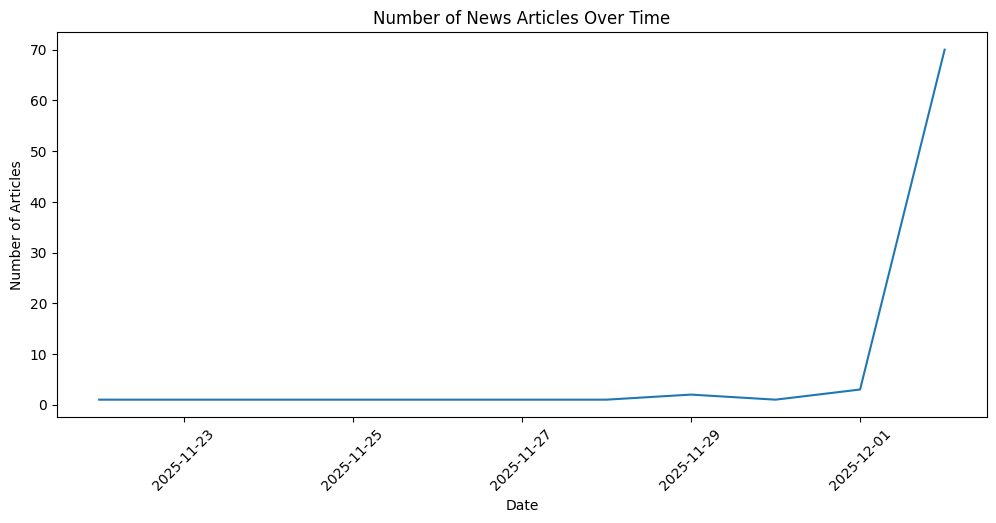

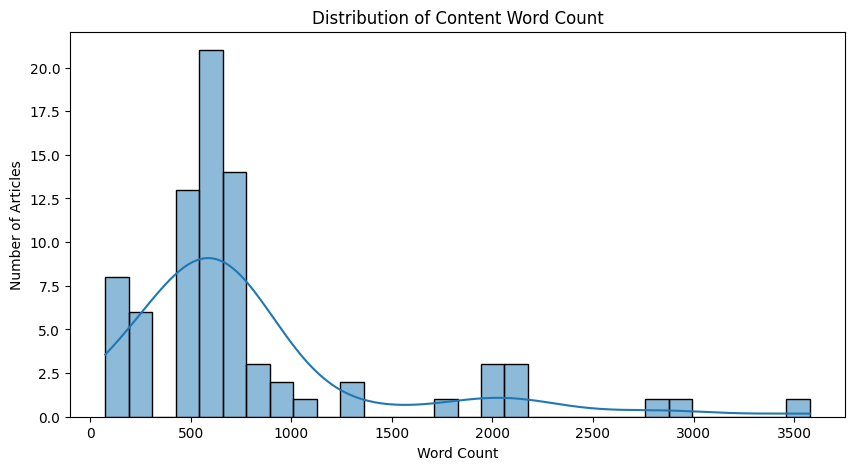

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


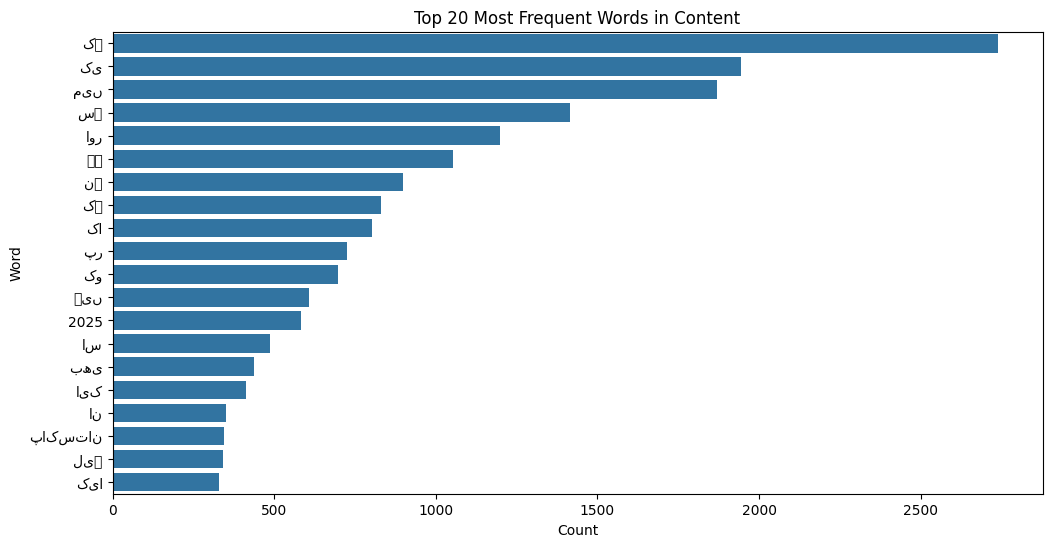

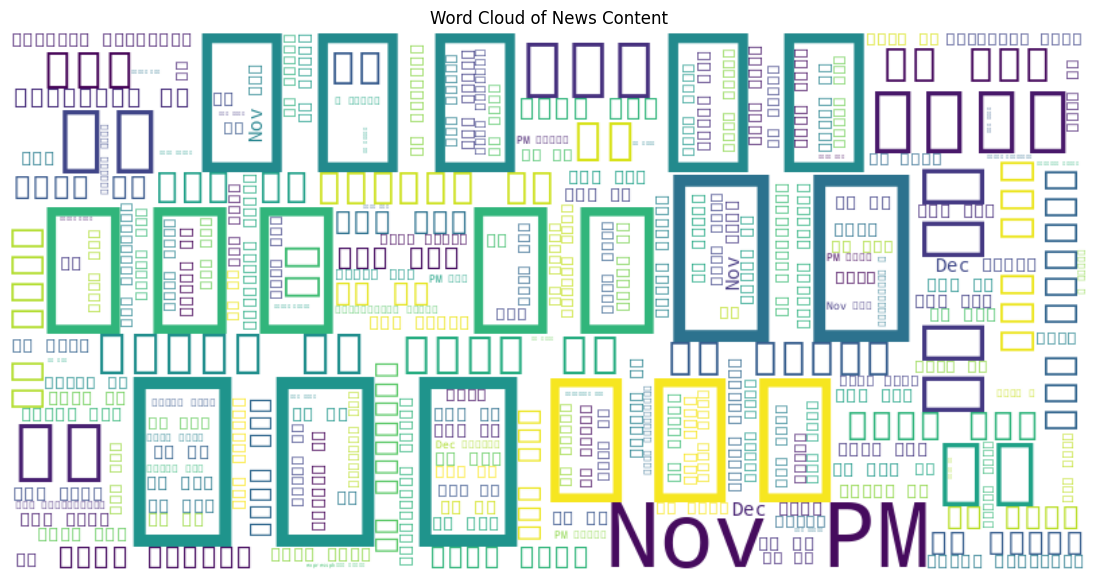

In [25]:
# --- Step 1: Import visualization libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# --- Step 2: News distribution over time ---
plt.figure(figsize=(12,5))
df['date'].dt.date.value_counts().sort_index().plot()
plt.title('Number of News Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# --- Step 3: Content length distribution ---
plt.figure(figsize=(10,5))
sns.histplot(df['content_word_count'], bins=30, kde=True)
plt.title('Distribution of Content Word Count')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

# --- Step 4: Most frequent words in content ---
all_words = ' '.join(df['cleaned_content']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Frequent Words in Content')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# --- Step 5: Word Cloud ---
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(all_words))
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Content')
plt.show()


In [26]:
# --- Step 1: Create a target column (Example: manual labeling) ---
# For demonstration, we’ll randomly assign labels. Replace with real labels later.
import numpy as np
np.random.seed(42)
df['target'] = np.random.randint(0, 2, size=len(df))  # 0 = Neutral, 1 = Hate Speech

# --- Step 2: Train/Test Split ---
from sklearn.model_selection import train_test_split

X = df['cleaned_content']   # Input text
y = df['target']            # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# --- Step 3: Text Vectorization (TF-IDF for classical ML) ---
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

# --- Step 4: Optional: Check a sample ---
print("Sample vectorized features:\n", X_train_tfidf[0].toarray()[:5])


Training samples: 64
Testing samples: 16
TF-IDF shape: (64, 5000)
Sample vectorized features:
 [[0.05520789 0.05520789 0.02208315 ... 0.         0.         0.        ]]


In [28]:
# --- Step 1: Import ML models and metrics ---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Step 2: Initialize all models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear)": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# --- Step 3: Train, predict and evaluate ---
results = []

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append((name, acc, f1))

    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Step 4: Summary of all models ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
print("\nSummary of all models:\n", results_df.sort_values(by="F1 Score", ascending=False))



Model: Logistic Regression
Accuracy: 0.5625
F1 Score: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.54      0.88      0.67         8

    accuracy                           0.56        16
   macro avg       0.60      0.56      0.52        16
weighted avg       0.60      0.56      0.52        16

Confusion Matrix:
 [[2 6]
 [1 7]]

Model: SVM (Linear)
Accuracy: 0.5
F1 Score: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.50      0.75      0.60         8

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.47        16
weighted avg       0.50      0.50      0.47        16

Confusion Matrix:
 [[2 6]
 [2 6]]

Model: Random Forest
Accuracy: 0.375
F1 Score: 0.4444444444444444
Classification Report:
               pr

In [30]:
# Install lxml with html_clean support
!pip install lxml[html_clean]

# OR install the standalone package
!pip install lxml_html_clean


In [31]:
# --- Step 1: Install required packages ---
!pip install newspaper3k beautifulsoup4 lxml urduhack feedparser

# --- Step 2: Import libraries ---
import pandas as pd
from newspaper import Article, Config
import feedparser
from tqdm import tqdm
import urduhack

urduhack.download()  # for text normalization

# --- Step 3: Define RSS feeds of Urdu news ---
rss_feeds = [
    "https://www.bbc.com/urdu/rss.xml",
    "https://www.geo.tv/rss/urdu.xml",
    "https://jang.com.pk/rss/urdu.xml"
]

# --- Step 4: Scrape articles ---
config = Config()
config.language = 'ur'  # Urdu

all_articles = []

for feed in rss_feeds:
    news_feed = feedparser.parse(feed)
    for entry in tqdm(news_feed.entries):
        url = entry.link
        try:
            article = Article(url, config=config)
            article.download()
            article.parse()

            # Normalize content
            content = urduhack.normalize(article.text)

            all_articles.append({
                'source': feed.split('/')[2],
                'title': article.title,
                'url': url,
                'date': entry.published if 'published' in entry else None,
                'content': content
            })
        except:
            continue

# --- Step 5: Create DataFrame ---
df_news = pd.DataFrame(all_articles)
print("Total articles scraped:", df_news.shape[0])

# --- Step 6: Save to CSV ---
df_news.to_csv('urdu_news_1000.csv', index=False, encoding='utf-8-sig')
print("Saved CSV as urdu_news_1000.csv")


36788015/36788015 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Total articles scraped: 0
Saved CSV as urdu_news_1000.csv


In [33]:
# =============================
# STEP 0: Install required packages
# =============================
!pip install newspaper3k beautifulsoup4 lxml urduhack feedparser tqdm scikit-learn matplotlib seaborn wordcloud

# =============================
# STEP 1: Import libraries
# =============================
import pandas as pd
import re
from newspaper import Article, Config
import feedparser
from tqdm import tqdm
import urduhack
urduhack.download()  # for text normalization

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np

# =============================
# STEP 2: Define RSS feeds
# =============================
rss_feeds = [
    "https://www.bbc.com/urdu/rss.xml",
    "https://jang.com.pk/rss/urdu.xml"
]

config = Config()
config.language = 'ur'

all_articles = []

# =============================
# STEP 3: Scrape articles
# =============================
for feed in rss_feeds:
    news_feed = feedparser.parse(feed)
    for entry in tqdm(news_feed.entries):
        url = entry.link
        try:
            article = Article(url, config=config)
            article.download()
            article.parse()

            # Normalize Urdu content
            content = urduhack.normalize(article.text)
            date = getattr(entry, 'published', None)

            all_articles.append({
                'source': feed.split('/')[2],
                'title': article.title,
                'url': url,
                'date': date,
                'content': content
            })
        except:
            continue

# =============================
# STEP 4: Create DataFrame
# =============================
df = pd.DataFrame(all_articles)
print("Total articles scraped:", df.shape[0])

# =============================
# STEP 5: Clean dataset
# =============================
df.drop_duplicates(inplace=True)
df.dropna(subset=['title', 'content'], inplace=True)

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces/newlines
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.strip()

df['cleaned_content'] = df['content'].apply(clean_text)
df['cleaned_title'] = df['title'].apply(clean_text)

# Combine title + content for modeling
df['text'] = df['cleaned_title'] + " " + df['cleaned_content']

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Optional features
df['content_word_count'] = df['cleaned_content'].apply(lambda x: len(x.split()))
df['content_char_count'] = df['cleaned_content'].apply(len)

print("After cleaning:", df.shape)

# =============================
# STEP 6: Visualization
# =============================
# 1. News distribution over time
plt.figure(figsize=(12,5))
df['date'].dt.date.value_counts().sort_index().plot()
plt.title('Number of News Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# 2. Content length distribution
plt.figure(figsize=(10,5))
sns.histplot(df['content_word_count'], bins=30, kde=True)
plt.title('Distribution of Content Word Count')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

# 3. Most frequent words
all_words = ' '.join(df['text']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 Most Frequent Words in Text')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# 4. Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(all_words))
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Text')
plt.show()

# =============================
# STEP 7: Prepare dataset for ML
# =============================
# For demonstration, assign random labels (replace with real labels!)
np.random.seed(42)
df['target'] = np.random.randint(0, 2, size=len(df))  # 0 = Neutral, 1 = Hate Speech

X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# =============================
# STEP 8: Train multiple ML models
# =============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear)": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append((name, acc, f1))

    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
print("\nSummary of all models:\n", results_df.sort_values(by="F1 Score", ascending=False))

# =============================
# STEP 9: Save cleaned dataset
# =============================
df.to_csv('urdu_news_cleaned_1000.csv', index=False, encoding='utf-8-sig')
print("Cleaned dataset saved as urdu_news_cleaned_1000.csv")


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Total articles scraped: 0


KeyError: ['title', 'content']